# 📚 Exercise Session - Week 4

Welcome to Week 4!

> **We will explore a set of tasks with `DistilBert` and `T5` model:**
> 1. [*(INTRO)* Understanding `DistilBert` and `T5`;](#1)
> 2. [**TASK A:** Sentiment Classification;](#2)
> 3. [**TASK B:** Natural Language Inference (NLI);](#3)
> 4. [**TASK C:** Sentence Similarity;](#4)
> 5. [**Task D:** Machine Translation using mT5](#5)

You'll learn about the mechanism of knowledge distillation and multi-task pretraining, and apply these pretrained models on various downstream tasks :)

### Setup  
We **strongly recommend** using a GPU for this exercise to speed up training and evaluation.  

You can access a free T4 GPU on [Google Colab](https://colab.research.google.com/) for this exercise. Refer to the [Google Colab Guide](https://hackmd.io/@BrownDeepLearningS24/BkIT3sW6s) for detailed instructions.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import evaluate

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
!unzip wmt14_fr_en_10k.zip

<a id="1"></a>
## INTRO: Understanding Your Models — `DistilBERT` and `T5` 🤖

Before diving into the tasks, let's take a moment to understand the models we'll be working with. **`DistilBERT`** is a streamlined version of `BERT`, designed using knowledge distillation, while **`T5`** is a versatile model known for its multi-task pretraining.

### `DistilBERT`: A Knowledge-Distilled Version of `BERT`
Knowledge distillation is a technique that transfers knowledge from a large, pretrained *teacher model* to a smaller, more efficient *student model*. **DistilBERT** leverages this approach during pretraining, using `BERT` as its frozen teacher model.

The training process incorporates three key loss components:

1. **Masked Language Modeling (MLM) Loss**: The student model predicts masked tokens and compares its predictions to the true labels.
  
2. **Distillation Loss**: Instead of relying solely on hard labels, the student model learns from the teacher's *soft predictions*—probability distributions over the vocabulary.
  
3. **Embedding Cosine Loss**: To further align the student with the teacher, the cosine distance between their sentence embeddings (from the last hidden layer) is minimized.

For more details, refer to the original [DistilBERT paper](https://arxiv.org/abs/1910.01108).


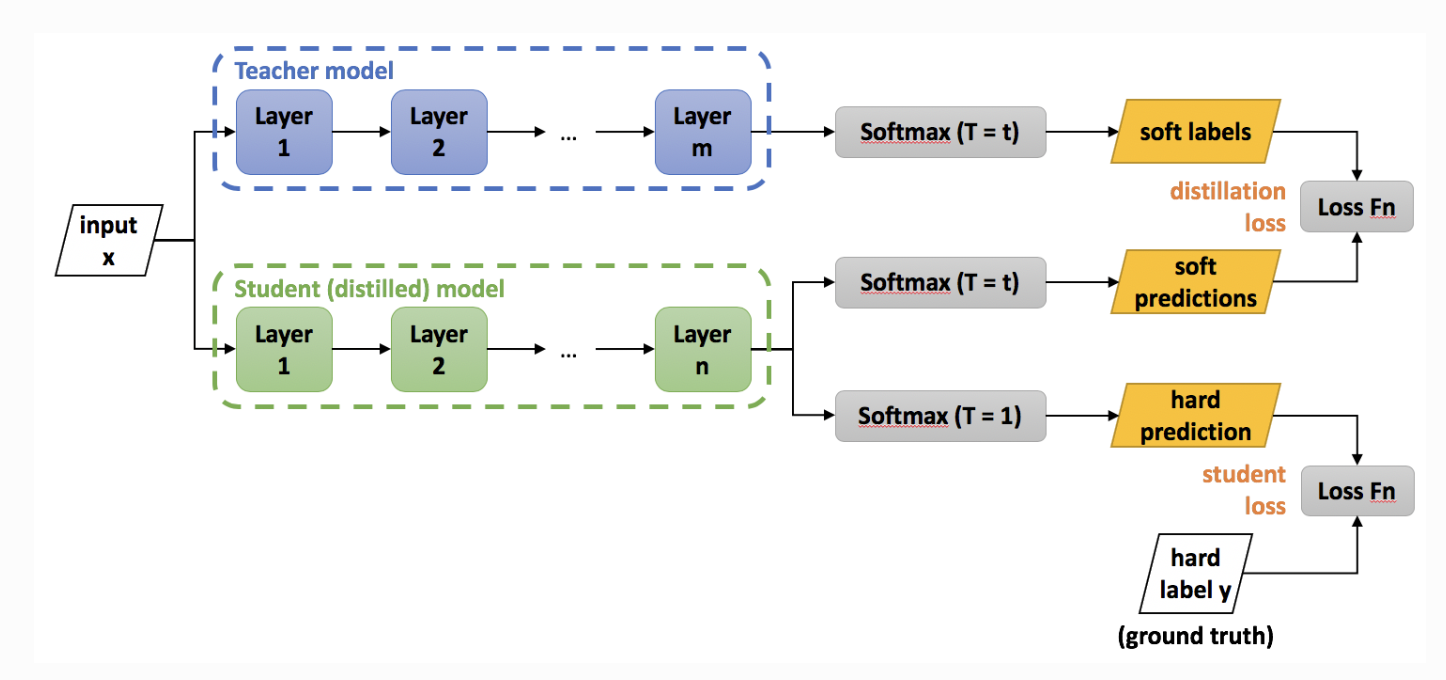

### `T5`: Multi-task Learning for Pretraining
Multi-task learning aims to train the model with better transfer learning capability.
**T5**-family is a set of models of various scales, pretrained on a diverse range of tasks including text classification, summarization, question-answering etc.

> We refer you to the original T5 paper for more details [here](https://arxiv.org/abs/1910.10683).

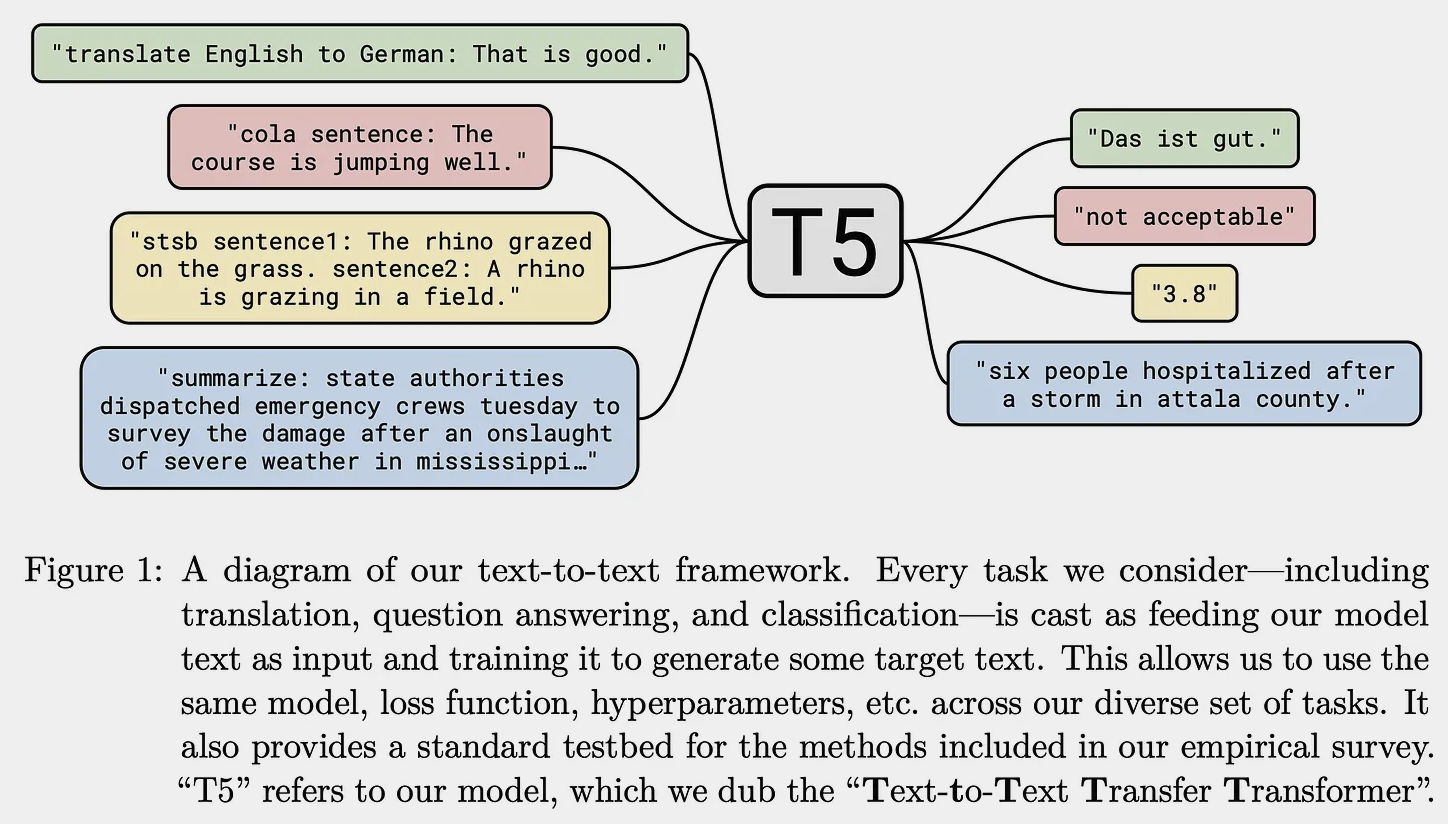

#### **Load Pretrained Models**

We can directly load pretrained model checkpoints from Huggingface [transformers](https://huggingface.co/docs/transformers/index), which provides access to more than 1M models.

We provide the function to load pretrained models and corresponding tokenizers by providing the name/path to the huggingface checkpoint.

**`TODO-1:Load model checkpoints.`**

You are required to load `distilbert` and `t5-small` models following the given links.

In [10]:
def load_pretrained(model_name, num_labels=2):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

  if torch.cuda.is_available():
    model = model.to('cuda:0')
  return tokenizer, model

In [ ]:
# TODO: Load DistilBert (https://huggingface.co/distilbert/distilbert-base-uncased)
distilbert_tokenizer, distilbert_model = load_pretrained('distilbert-base-uncased')

# TODO: Load T5-small (https://huggingface.co/google-t5/t5-small)
t5_tokenizer, t5_model = load_pretrained('t5-small')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id=2></a>
## Task-A: Sentiment Analysis

First, we will fine-tune and evaluate `distilbert` model on a movie sentiment analysis task. Specifically, we will use the [IMDB](https://huggingface.co/datasets/imdb) dataset.

**`TODO-2: Load IMDB Dataset`**


In [ ]:
def load_data(dataset_name):
  data = load_dataset(dataset_name)
  return data

# TODO: load IMDB dataset (https://huggingface.co/datasets/imdb)
imdb_data = load_data('imdb')

train_data = imdb_data['train']
test_data = imdb_data['test']

print('#Training samples: ', len(train_data))
print('#Test samples: ', len(test_data))

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

#Training samples:  25000
#Test samples:  25000


In [ ]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
# Check what is in the data loader?
for b in test_loader:
  print(b['text'])
  print(b['label'])
  break

['I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they hav

**`TODO-3: Implement Evaluation Function`**

We first evaluate the model before fine-tuning on the subsampled `test_data`.

In [ ]:
def evaluate_model(model, tokenizer, test_loader):
  """
    Evaluates a text classification model's performance on a test dataset.
    Parameters:
    - model (torch.nn.Module): The model to be evaluated.
    - tokenizer (transformers.PreTrainedTokenizer):
        The tokenizer used to process the text data into a format that the model can
        understand.
    - test_loader (torch.utils.data.DataLoader): A DataLoader containing the test
        dataset.
    Returns:
    - all_preds (torch.Tensor): A tensor containing all the predictions made by the
        model on the test dataset.
    - all_labels (torch.Tensor): A tensor containing all the labels in the test dataset.
    - acc (float): The overall accuracy of the model on the test dataset.
    - f1 (float): The F1 score of the model on the test dataset.
  """
  all_labels = None
  all_preds = None

  for b in tqdm(test_loader):
    text = b['text']
    label = b['label']

    # TODO: tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    if torch.cuda.is_available():
      inputs = inputs.to('cuda:0')
      label = label.to('cuda:0')

    # TODO: run the model to make the prediction
    with torch.no_grad():
        pred = model(**inputs).logits.argmax(dim=-1)

    if all_labels is None:
      all_labels = label.cpu()
      all_preds = pred.cpu()
    else:
      all_labels = torch.concat([all_labels, label.cpu()])
      all_preds = torch.concat([all_preds, pred.cpu()])

  assert len(all_preds)==len(all_labels), 'Test Failed. Check your code!'
  # TODO: compute f1 score between model predictions and ground-truth labels (you can use sklearn.metrics)
  f1 = f1_score(all_labels, all_preds)

  # TODO: compute accuracy score between model predictions and ground-truth labels (you can use sklearn.metrics)
  acc = accuracy_score(all_labels, all_preds)

  # TODO: compute the accuracy on Positive(label==1) samples
  pos_acc = accuracy_score(all_labels[all_labels==1], all_preds[all_labels==1])

  # TODO: compute the accuracy on Negative(label==0) samples
  neg_acc = accuracy_score(all_labels[all_labels==0], all_preds[all_labels==0])

  print('Accuracy: ', acc*100, '%')
  print(' -- Positive Accuracy: ', pos_acc*100, '%')
  print(' -- Negative Accuracy: ', neg_acc*100, '%')
  print('F1 score: ', f1)

  return all_preds, all_labels, acc, f1

In [ ]:
# ETS: <10mins on colab T4 gpu
all_preds, all_labels, acc, f1 = evaluate_model(distilbert_model, distilbert_tokenizer, test_loader)

100%|██████████| 1563/1563 [06:09<00:00,  4.23it/s]

Accuracy:  50.048 %
 -- Positive Accuracy:  0.192 %
 -- Negative Accuracy:  99.90400000000001 %
F1 score:  0.0038289725590299937


**Thinking**: What do you observed from the evaluation results? Why do you think that could happen?

<a name="sent2"></a>
## A.2 Finetuned model

Now lets try to fine-tune DistilBERT on IMDB training dataset.



**`TODO-4`: Prepare the training data and data collator**

In [ ]:
# TODO: Define a function to tokenize the text
def tokenize_function(examples):
  return distilbert_tokenizer(examples["text"], truncation = True)

# TODO: Tokenize the training data
tokenized_train = train_data.map(tokenize_function, batched = True)

# TODO: Define a data collator to handle padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer = distilbert_tokenizer)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

**`TODO-5`: Define the `TrainingArguements` and `Trainer`.**

In [ ]:
# Import the trainer and training arguments
from transformers import TrainingArguments, Trainer

# Define the output directory and other training arguments
output_dir_name = "imdb-ft-distilbert"

training_args = TrainingArguments(

   output_dir = output_dir_name,
   learning_rate = 2e-5,
   per_device_train_batch_size = 16,
   per_device_eval_batch_size = 16,
   num_train_epochs = 1,
   weight_decay = 0.01,
   save_strategy = "epoch",
   push_to_hub = False,
   report_to="none"
)

# TODO: Initialize the trainer
trainer = Trainer(
   model = distilbert_model,
   args = training_args,
   train_dataset = tokenized_train,
   tokenizer = distilbert_tokenizer,
   data_collator = data_collator,
)

<ipython-input-19-5ca6aecb2e1f>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Start training (fine-tuning)!

In [ ]:
# ETS: ~20mins to train on colab t4 gpu
trainer.train()

Step,Training Loss
500,0.318400
1000,0.238400
1500,0.214900


TrainOutput(global_step=1563, training_loss=0.25560504476458157, metrics={'train_runtime': 1165.8529, 'train_samples_per_second': 21.444, 'train_steps_per_second': 1.341, 'total_flos': 3280166004732288.0, 'train_loss': 0.25560504476458157, 'epoch': 1.0})

Evaluate on the test set: How's the performance compared to the previous model without fine-tuning?

In [ ]:
# ETS: <10mins on colab T4 gpu
all_preds, all_labels, acc, f1 = evaluate_model(distilbert_model, distilbert_tokenizer, test_loader)

100%|██████████| 1563/1563 [06:23<00:00,  4.07it/s]

Accuracy:  92.51599999999999 %
 -- Positive Accuracy:  91.75999999999999 %
 -- Negative Accuracy:  93.272 %
F1 score:  0.9245898996412881


Then we can create a sentiment analysis pipeline using this finetuned model :)

In [ ]:
from transformers import pipeline

# Creating a pipeline for testing the model
distilbert_model.to('cpu')
class_labels = ['Negative', 'Positive']
distilbert_model.config.id2label = class_labels
sentiment_model = pipeline(task = 'sentiment-analysis', model = distilbert_model, tokenizer = distilbert_tokenizer)

Device set to use cuda:0


In [ ]:
# Testing the model on a sample text
sentiment_model("I love this movie")

# TODO: Testing on your own created text
# sentiment_model(...)

[{'label': 'Positive', 'score': 0.9891007542610168}]

<a id=3></a>
## Task-B. Natural language Inference

Now we will look at a DistilBERT model which has been fine-tuned on NLI data. Specifically it has been fine-tuned on on the MNLI task of the [GLUE benchmark](https://gluebenchmark.com/).


In this dataset, the model is given a pair of sentences (`premise` and `hypothesis`). The pair has either the label "*entail*", meaning the first sentence implies the second; "*contradict*", meaning the second sentence must be false given the first; or '*neutral*", meaning you can not judge the second sentence to be true or false given the first sentence.

We first need to load the `mnli` dataset from GLUE benchmark, and build the dataloader like before:

In [11]:
mnli = load_dataset("glue",'mnli_matched')
mnli_test = mnli["validation"]

mnli_test_loader = DataLoader(mnli_test, batch_size=16, shuffle=False)

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Here, we directily load the finetuned distilbert model from huggingface.


**`TODO-6`: load the model finetuned on nli tasks from huggingface.** (https://huggingface.co/sentence-transformers/nli-distilbert-base)

In [15]:
nli_ft_distilbert_tokenizer, nli_ft_distilbert_model = load_pretrained('cross-encoder/nli-roberta-base', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

**`TODO-7: Implement Evaluation Function for NLI tasks`**

what shall we change from the last version? You can look into the dataset components to see the difference.

In [26]:
def evaluate_model_nli(model, tokenizer, test_loader):
  all_labels = None
  all_preds = None

  for b in tqdm(test_loader):
    premise = b['premise']
    hypothesis = b['hypothesis']
    label = b['label']

    # TODO: tokenize the text
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True)
    if torch.cuda.is_available():
      inputs = inputs.to('cuda:0')
      label = label.to('cuda:0')

    # TODO: run the model to make the prediction
    with torch.no_grad():
        pred = model(**inputs).logits.argmax(dim=-1)

    if all_labels is None:
      all_labels = label.cpu()
      all_preds = pred.cpu()
    else:
      all_labels = torch.concat([all_labels, label.cpu()])
      all_preds = torch.concat([all_preds, pred.cpu()])

  assert len(all_preds)==len(all_labels), 'Test Failed. Check your code!'

  label_mapping = ['contradiction', 'entailment', 'neutral']
  map_preds = {1: 0, 2: 1, 0: 2}
  all_preds = torch.tensor([map_preds[pred.item()] for pred in all_preds])

  # TODO: compute f1 score between model predictions and ground-truth labels (you can use sklearn.metrics)
  f1 = f1_score(all_labels, all_preds, average='macro')

  # TODO: compute accuracy score between model predictions and ground-truth labels (you can use sklearn.metrics)
  acc = accuracy_score(all_labels, all_preds)


  # TODO: compute the accuracy on Entailment(label==0) samples
  entailment_acc = accuracy_score((all_labels[all_labels==0]==0), (all_preds[all_labels==0]==0))

  # TODO: compute the accuracy on Neutral(label==1) samples
  neutral_acc = accuracy_score((all_labels[all_labels==1]==1), (all_preds[all_labels==1]==1))

  # TODO: compute the accuracy on Contradict(label==2) samples
  contradict_acc = accuracy_score((all_labels[all_labels==2]==2), (all_preds[all_labels==2]==2))

  print('Accuracy: ', acc*100, '%')
  print(' -- Entailment Accuracy: ', entailment_acc*100, '%')
  print(' -- Neutral Accuracy: ', neutral_acc*100, '%')
  print(' -- Contradict Accuracy: ', contradict_acc*100, '%')
  print('F1 score: ', f1)

  return all_preds, all_labels, acc, f1

In [27]:
# ETS: <1min on colab T4 gpu
all_preds, all_labels, acc, f1 = evaluate_model_nli(nli_ft_distilbert_model, nli_ft_distilbert_tokenizer, mnli_test_loader)

100%|██████████| 614/614 [00:43<00:00, 14.16it/s]

Accuracy:  87.32552215995925 %
 -- Entailment Accuracy:  86.74906582351251 %
 -- Neutral Accuracy:  84.37399935959013 %
 -- Contradict Accuracy:  90.81854964207905 %
F1 score:  0.8726297213178379


<a id=4></a>
## Task-C. Sentence Similarity

Next we will be using pre-trained models to perform a task that fits under the umbrella of sentence similarity. Specifically, we will be looking at **Detecting Duplicate Questions (ddp)**, in which the model needs to determine, given two questions, whether or not they are duplicates.

<a name="ss0"></a>
### `SBERT`

Unlike the previous tasks, which used token level embeddings, in order to perform this task we will use sentence level embeddings. Specifically we will be using SBERT, which was originally proposed in [this paper](https://arxiv.org/abs/1908.10084).

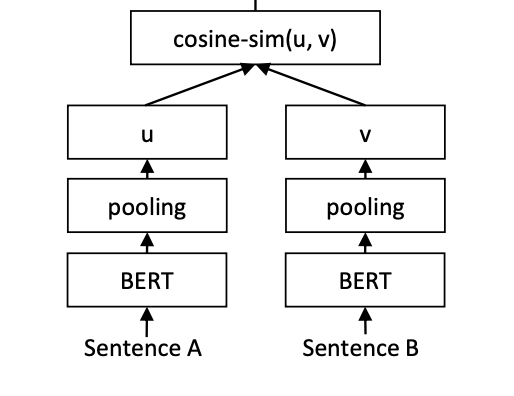

There are two important features of this model. First, on top of a transformer layer, there is a pooling layer, which pools the token level embeddings into a single sentence level embedding. Second, the network uses a siamese arctitecture. This means that the two sentences are embedded seperately from eachother. The graph in the paper can be a little misleading, at first glance it makes it appear as if sentence 1 and sentence 2 are fed into seperate BERT/pooling layers. In reality the BERT/pooling layers on either side of SBERT is the same network.

Another important thing to keep in mind is that the data was not trained on the task we are evaluating. It was trained on some NLI tasks, as well as a question answering task, but it has not seen duplicate question data.

We will be using the sentence transformer [library](https://www.sbert.net/#). The "Semantic Textual Similarity" tab on the left of their website will be the most useful in guiding you with the code.

First we import the model from `SentenceTransformer` library and load ddp data from the given `test_pairs` data file.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
quora_ddq = pd.read_excel('test_pairs.xlsx')
quora_ddq.head(10)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,qid1,qid2,question1,question2,is_duplicate
0,219237,2646,"What is the ""Best pick-up line"" you ever heard...",What are the best pick up lines?,0
1,401324,447225,What is screening?,Was Shakespeare bisexual?,0
2,489618,324606,"If someone refuses to pay their debts, despite...",How does one graduate from a UC without much d...,0
3,3335,3336,"Marx said ""The religion is opium of the people...",Why are the Indian Left called anti-Hindu when...,0
4,100509,253822,What is the use of an HDMI port in an LED TV?,I tried connecting my Toshiba tv to a laptop w...,0
5,201198,201199,What is the compatibility between a pisces sun...,What is the compatibility between a Scorpio su...,0
6,523957,523958,What should I be aware of in New York? I want ...,I Had Sex For The First Time. Will I Get Pregn...,0
7,228739,228740,Idont want deduction in pf from my?,Is there any serious competitor to Android OS ...,0
8,170284,170285,Why does America have nuclear weapons? Isn't i...,Why is America allowed to have and use nuclear...,1
9,293723,293724,What is the process and procedure to get EPFO ...,Pension Funds: How can we add a new PF account...,0


Then you can playwith the model!

Get a subset of the questions that will be fed into the model

In [ ]:
questions1 = quora_ddq['question1'][0:100]
questions2 = quora_ddq['question2'][0:100]

**`TODO-8: encode all the sentences with the sentencebert model`**

*Hint: you can check [`encode`](https://www.sbert.net/docs/package_reference/SentenceTransformer.html#sentence_transformers.SentenceTransformer.encode) method from `sentence-transformer`*

In [ ]:
embeddings1 = model.encode(questions1, convert_to_tensor=True)
embeddings2 = model.encode(questions2, convert_to_tensor=True)

**`TODO-9: Get the scores for each question pair.`**

You will need to:

1) recieve `cosine_similarity` score from the output.

2) choose a cutoff to decide the similarity scores above which could represent "same", not just "a bit similar".

*Hint: you can check [`util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html) method from `sentence-transformer`*

In [ ]:
# TODO: recieve cosine_similarity score from the output.
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# TODO: choose a cutoff to decide the similarity scores above which could represent "same", not just "a bit similar".
scores = [1 if cosine_scores[i][i]>0.75 else 0 for i in range(len(questions1))]

Check the accuracy/F1 of the model

In [ ]:
quora_ddq_subset = pd.DataFrame(quora_ddq[0:100])
quora_ddq_subset['guess'] = scores

print("Accuracy :", accuracy_score(quora_ddq_subset['is_duplicate'], quora_ddq_subset['guess']))
print("Positive Accuracy :", accuracy_score(quora_ddq_subset[quora_ddq_subset['is_duplicate']==1]['is_duplicate'], quora_ddq_subset[quora_ddq_subset['is_duplicate']==1]['guess']))
print("Negative Accuracy :", accuracy_score(quora_ddq_subset[quora_ddq_subset['is_duplicate']==0]['is_duplicate'], quora_ddq_subset[quora_ddq_subset['is_duplicate']==0]['guess']))

print("F1 :", f1_score(quora_ddq_subset['is_duplicate'], quora_ddq_subset['guess'], average = 'micro'))


Accuracy : 0.77
Positive Accuracy : 0.8974358974358975
Negative Accuracy : 0.6885245901639344
F1 : 0.77


<a id=5></a>
# Task-D. Finetune mT5-Small for Machine Translation

1. **Objective**  
   - You will build on your earlier tasks by fine-tuning a multilingual T5 model on the same Week 3 machine translation dataset.
   - Your goal is to improve the translation quality and then measure the effectiveness of your finetuned model using a machine translation metric.

2. **Data Preparation**  
   - Use the Week 3 machine translation dataset. Ensure it is properly formatted (e.g., source-target pairs) for input into a T5 model.
   - Split the dataset into training and validation sets if you have not already done so.

3. **Model Setup**  
   - Load your multilingual T5 checkpoint. Make sure to include any special tokens or prefixes (e.g., “translate <SRC_LANG> to <TGT_LANG>:”) that the model might need to correctly learn the translation task.
   - Configure hyperparameters such as the learning rate, batch size, and number of training epochs based on your available resources and the size of your dataset.

4. **Fine-tuning Procedure**  
   - Implement a training loop or use a library function (e.g., HuggingFace’s `Trainer`) to finetune the multilingual T5 model.  
   - During training, ensure you:
     - Shuffle the dataset.
     - Monitor the loss on both training and validation sets.
     - Use appropriate checkpoints or logging for progress tracking.

5. **Evaluation**  
   - After training, evaluate your final model using the provided machine translation metric.  
   - Report your metric’s score (e.g., SacreBLEU).  
   - Generate a few example translations to illustrate the model’s performance.


In [4]:
from datasets import load_from_disk
# Load the dataset
data = load_from_disk('wmt14_fr_en_10k')
data["train"] = data["train"].select(range(3000))
data["validation"] = data["validation"].select(range(50))
print(data)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 50
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})


In [5]:
# Load tokenizer and model
model_name = "google/mt5-small"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Preprocess function for tokenization
#    We'll prepend a prompt like "translate English to French: " to the source.
def preprocess_function(examples):
    prefix = "translate English to French: "
    inputs = [prefix + src["en"] for src in examples["translation"]]
    targets = [tgt["fr"] for tgt in examples["translation"]]

    model_inputs = tokenizer(inputs, text_target=targets, max_length=64, truncation=True)
    return model_inputs

tokenized_datasets = data.map(preprocess_function, batched=True)

# Set up DataCollator (handles dynamic padding)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Load the metric (SacreBLEU)
bleu_metric = evaluate.load("sacrebleu")

# Define the compute_metrics function for the Trainer
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convert token IDs back to text
    predictions = [[(p if p != -100 else tokenizer.pad_token_id) for p in prediction] for prediction in predictions]
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in labels as the padding token ID, then decode
    labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # SacreBLEU expects a list of prediction strings, plus a list of lists for references
    results = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[lbl] for lbl in decoded_labels]
    )
    return {"bleu": results["score"]}

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-small-translation",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="no",
    logging_steps=1,
    push_to_hub=False,
    report_to="none",
    predict_with_generate=True,
    generation_max_length=64,
    eval_steps=0.05,
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Evaluate on the validation set
metrics = trainer.evaluate()
print("Evaluation metrics:", metrics)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/3003 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-ef3d9b08ed30>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu
1,4.496700,2.316401,0.750942
2,3.556400,1.987056,3.159753
3,3.306000,1.864056,3.304361
4,3.242400,1.799541,5.126635
5,3.201600,1.749214,5.456690
6,2.840400,1.710388,7.380928
7,2.892200,1.699605,7.788193
8,2.867900,1.685546,8.196492
9,2.994100,1.674532,9.674986
10,3.174600,1.670802,10.038463


Evaluation metrics: {'eval_loss': 1.6708018779754639, 'eval_bleu': 10.038462836566035, 'eval_runtime': 13.1128, 'eval_samples_per_second': 3.813, 'eval_steps_per_second': 0.991, 'epoch': 10.0}


In [6]:
generations = trainer.predict(tokenized_datasets["validation"].select(range(10)))

In [9]:
for i in range(10):
  prediction_token_ids = [token_id for token_id in generations.predictions[i] if token_id != -100]
  pred = tokenizer.decode(prediction_token_ids, skip_special_tokens=True)
  labels = generations.label_ids[i]
  labels = [l for l in labels if l != -100]
  ground_truth = tokenizer.decode(labels, skip_special_tokens=True)
  print(f"Prediction: {pred}\nGround Truth: {ground_truth}\n")

Prediction: Le plan de l'élection Republicane a été appliqué à la relection de Barack Obama.
Ground Truth: Une stratégie républicaine pour contrer la réélection d'Obama

Prediction: Le Parti de l'opposition a justifié son politique par la nécessité de combattre la fraude électorale.
Ground Truth: Les dirigeants républicains justifièrent leur politique par la nécessité de lutter contre la fraude électorale.

Prediction: Le Centre Brennan Centre a été très sceptique, dont le nombre de personnes sont morts par la flamme.
Ground Truth: Or, le Centre Brennan considère cette dernière comme un mythe, affirmant que la fraude électorale est plus rare aux États-Unis que le nombre de personnes tuées par la foudre.

Prediction: Le Conseil Republicans a identifié près de 300 cas de fraude électorale dans les États-Unis en deux ans.
Ground Truth: D'ailleurs, les avocats républicains n'ont recensé que 300 cas de fraude électorale aux États-Unis en dix ans.

Prediction: Le principe est certain: ces di

<a name="conc"></a>
## 5. Conclusion

Congrats! Now you have seen how pretrained/finetuned `DistilBert` models have performed on a variety of tasks and finetuned multilingual T5 on a machine translation task!